In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import missingno as msno
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
from sklearn.metrics import precision_score, classification_report,average_precision_score, accuracy_score, balanced_accuracy_score, precision_recall_curve, f1_score, auc, roc_curve

In [15]:
original_data = pd.read_csv('training_dataset.psv', sep ='|')

In [16]:
original_data.shape

(1361672, 41)

In [17]:
# dropping NA values and removing missing values over 92+ %
training_data = pd.read_csv('fe_train.csv')

In [18]:
training_data.shape

(1361664, 12)

C:\Users\Bulbul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


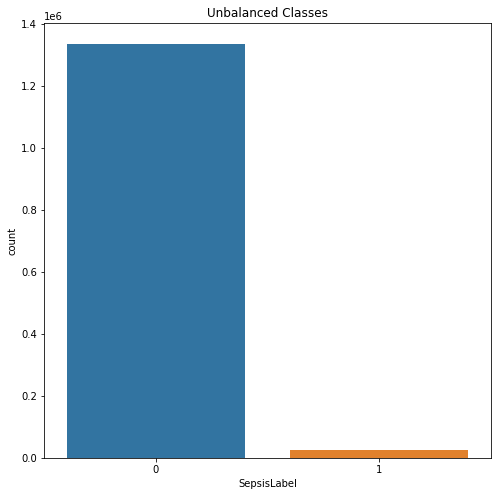

In [19]:
plt.figure(figsize=(8, 8))
sns.countplot('SepsisLabel', data=training_data)
plt.title('Unbalanced Classes')
plt.show()

In [20]:
testing_data = pd.read_csv('fe_test.csv')

In [21]:
testing_data.shape

(190615, 12)

C:\Users\Bulbul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


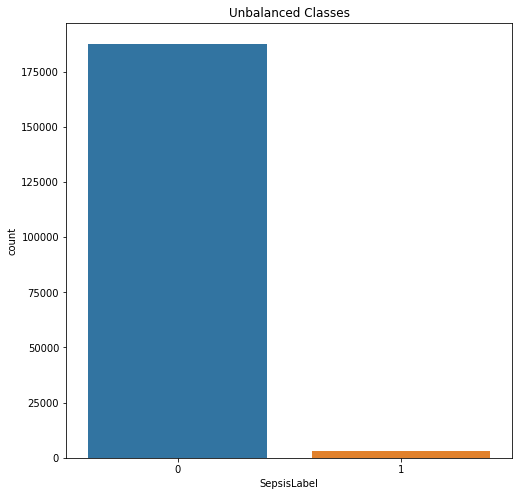

In [22]:
plt.figure(figsize=(8, 8))
sns.countplot('SepsisLabel', data=testing_data)
plt.title('Unbalanced Classes')
plt.show()

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
le = LabelEncoder()

In [25]:
# Encode training data
for col in training_data.columns.values:
    # Encoding only categorical variables
    if training_data[col].dtypes=='object':
        # Using whole data to form an exhaustive list of levels
        data=training_data[col]
        le.fit(data.values)
        training_data[col]=le.transform(training_data[col])

In [26]:
training_data.head()

,Gender,new_age,new_o2sat,new_temp,new_bp,new_resp,new_map,new_fio2,new_hr,HospAdmTime,ICULOS,SepsisLabel
0,0,1,1,0,0,1,0,0,0,-0.03,1,0
1,0,1,2,0,0,2,2,0,0,-0.03,2,0
2,0,1,2,0,0,0,2,0,0,-0.03,3,0
3,0,1,2,0,0,0,0,0,0,-0.03,4,0
4,0,1,0,0,0,0,2,2,1,-0.03,5,0


In [27]:

# Encode training data
for col in testing_data.columns.values:
    # Encoding only categorical variables
    if testing_data[col].dtypes=='object':
        # Using whole data to form an exhaustive list of levels
        data=testing_data[col]
        le.fit(data.values)
        testing_data[col]=le.transform(testing_data[col])

In [28]:
testing_data.head()

,Gender,new_age,new_o2sat,new_temp,new_bp,new_resp,new_map,new_fio2,new_hr,HospAdmTime,ICULOS,SepsisLabel
0,1,1,1,0,0,1,0,0,0,-43.69,1,0
1,1,1,2,0,0,1,1,0,0,-43.69,2,0
2,1,1,2,2,0,1,1,0,0,-43.69,3,0
3,1,1,2,0,0,1,1,0,0,-43.69,4,0
4,1,1,2,2,0,1,2,0,0,-43.69,5,0


In [29]:
cols = ['Gender', 'new_age', 'new_o2sat', 'new_temp', 'new_bp', 'new_resp', 'new_map', 'new_fio2', 'new_hr', 'HospAdmTime', 'ICULOS']

X_train = training_data[cols]
y_train = training_data['SepsisLabel']

In [30]:
X_test = testing_data[cols]
y_test = testing_data['SepsisLabel']

In [31]:
#Create an object of the classifier.

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [32]:
# Train the classifier

bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=0)

In [33]:
# predict class values
dt_pred = bbc.predict(X_test)
dt_pred.sum()

20723

In [34]:
y_test

0         0
1         0
2         0
3         0
4         0
         ..
190610    0
190611    0
190612    0
190613    0
190614    0
Name: SepsisLabel, Length: 190615, dtype: int64

In [45]:
# predict probabilities
dt_prob = bbc.predict_proba(X_test)

In [46]:

# keep probabilities for the positive outcome only
dt_prob = dt_prob[:, 1]

In [47]:
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_prob)
dt_f1, dt_auc = f1_score(y_test, dt_pred), auc(dt_recall, dt_precision)

In [48]:
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (dt_f1, dt_auc))

Logistic: f1=0.097 auc=0.059


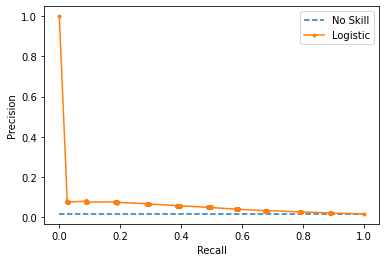

In [49]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(dt_recall, dt_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [50]:
fpr, tpr, _ = roc_curve(y_test, dt_pred)

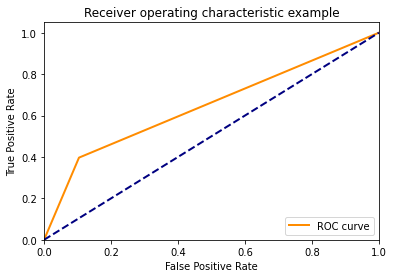

In [51]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [53]:
from xgboost import XGBClassifier

In [54]:
xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=300, max=5)

In [55]:
xgb_model.fit(X_train, y_train)

C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max=5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
pred_xgb = xgb_model.predict(X_test)

C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [57]:
predictions = [round(value) for value in pred_xgb]

accuracy = balanced_accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 50.03%


In [58]:

### Training with balanced bagging classifer

bbc_xgb = BalancedBaggingClassifier(base_estimator=XGBClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [59]:
bbc_xgb.fit(X_train, y_train)

C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


BalancedBaggingClassifier(base_estimator=XGBClassifier(base_score=None,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       gamma=None, gpu_id=None,
                                                       importance_type='gain',
                                                       interaction_constraints=None,
                                                       learning_rate=None,
                                                       max_delta_step=None,
                                                       max_depth=None,
                                                       min_child_weight=None,
                                                       missing=nan,
            

In [60]:
preds_xgb = bbc.predict(X_test)

In [61]:
accuracy_score(y_test, preds_xgb)
#accuracy_score(y_train,preds_xgb)

0.888141017233691

In [62]:
# Predict probabilities
xgb_prob = bbc_xgb.predict_proba(X_test)
xgb_prob

C:\Users\Bulbul\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([[0.56769897, 0.43230103],
       [0.57727494, 0.42272507],
       [0.66908587, 0.33091413],
       ...,
       [0.8184242 , 0.18157579],
       [0.84911531, 0.15088468],
       [0.81103018, 0.18896982]])

In [63]:
# keep probabilities for the positive outcome only
xgb_prob = xgb_prob[:, 1]

In [64]:
# Get precision, recall values
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, preds_xgb)
xgb_f1, xgb_auc = f1_score(y_test, preds_xgb), auc(xgb_recall, xgb_precision)

In [65]:
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))

Logistic: f1=0.097 auc=0.231


In [66]:
fpr, tpr, _ = roc_curve(y_test, preds_xgb)

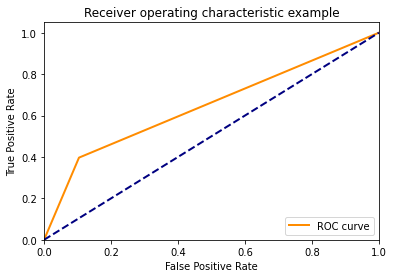

In [67]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

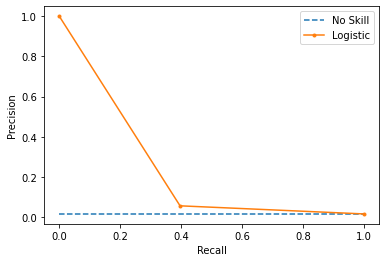

In [68]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [69]:
average_precision = average_precision_score(y_test, pred_xgb)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.02
